# Phase 3: Calculate Drift and Simulate Drift

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture

from alibi_detect.cd import KSDrift

from src.models.train_model import DataRepository, DataSplitter, PreprocessingBuilder

In [51]:
# Read data
df = DataRepository().load('../../data/clean/steel_energy_clean.csv')

df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0.0,WEEKDAY,MONDAY,LIGHT_LOAD,907.000000
1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900.0,WEEKDAY,MONDAY,LIGHT_LOAD,649.000000
2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,WEEKDAY,MONDAY,LIGHT_LOAD,497.651857
3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,WEEKDAY,MONDAY,LIGHT_LOAD,696.000000
4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,WEEKDAY,MONDAY,LIGHT_LOAD,630.000000


In [52]:
# Split the data accordingly
X_train, X_test, y_train, y_test = DataSplitter().split(df)

In [53]:
# Preprocess data
pipeline, cat_cols, num_cols = PreprocessingBuilder().build(X_train)

X_train_proc = pd.DataFrame(pipeline.fit_transform(X_train), columns=pipeline.get_feature_names_out())

X_train_proc.head()

,num__Usage_kWh,num__Lagging_Current_Reactive.Power_kVarh,num__Leading_Current_Reactive_Power_kVarh,num__CO2(tCO2),num__Lagging_Current_Power_Factor,num__Leading_Current_Power_Factor,num__NSM,num__mixed_type_col,cat__WeekStatus_WEEKDAY,cat__WeekStatus_WEEKEND,cat__Day_of_week_FRIDAY,cat__Day_of_week_MONDAY,cat__Day_of_week_SATURDAY,cat__Day_of_week_SUNDAY,cat__Day_of_week_THURSDAY,cat__Day_of_week_TUESDAY,cat__Day_of_week_WEDNESDAY
0,0.182649,0.255175,-0.136976,-0.059982,-0.048626,-0.028632,0.055408,1.538311,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.130214,0.169158,-0.136976,-0.059982,-0.045028,-0.028632,0.065546,-0.004319,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.354979,0.344357,-0.136976,-0.059475,-0.036176,-0.028632,-0.010492,0.381384,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.091658,-0.139324,0.241964,-0.060488,0.949279,-0.115987,-0.040907,-0.004319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.132774,-0.199471,0.362968,-0.060742,-0.006333,-0.201850,-0.025700,-0.004319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
# Use GaussianMixture to learn distribution
meanshift = -0.3
n_components = 5
random_state = 3

feature = 'num__Usage_kWh'

gmm = GaussianMixture(n_components=n_components, random_state=random_state).fit(X_train_proc[feature].to_numpy().reshape(-1,1))
print('Original Means: \n', gmm.means_)

# Modify the means
mod_means = gmm.means_.copy()
for i in range(n_components):
    mod_means[i] *= (1 + meanshift)

# Assign the modified means back to gmm
gmm.means_ = mod_means
print('Modified Means: \n', mod_means)

# Generate synthetic data with shifted means
synthetic_data = X_train_proc.copy()
synthetic_data[feature] = gmm.sample(int(X_train_proc.describe()[feature]['count']))[0].reshape(-1)
X_synthetic = synthetic_data[X_train_proc.columns].values
y_synthetic = y_train.copy().values

Original Means: 
 [[-0.05049425]
 [25.45296892]
 [47.55003834]
 [ 2.4486048 ]
 [12.88411729]]
Modified Means: 
 [[-0.03534598]
 [17.81707824]
 [33.28502684]
 [ 1.71402336]
 [ 9.0188821 ]]


In [55]:
# Check data sampling
display(X_train_proc.head(1))
display(synthetic_data.head(1))

,num__Usage_kWh,num__Lagging_Current_Reactive.Power_kVarh,num__Leading_Current_Reactive_Power_kVarh,num__CO2(tCO2),num__Lagging_Current_Power_Factor,num__Leading_Current_Power_Factor,num__NSM,num__mixed_type_col,cat__WeekStatus_WEEKDAY,cat__WeekStatus_WEEKEND,cat__Day_of_week_FRIDAY,cat__Day_of_week_MONDAY,cat__Day_of_week_SATURDAY,cat__Day_of_week_SUNDAY,cat__Day_of_week_THURSDAY,cat__Day_of_week_TUESDAY,cat__Day_of_week_WEDNESDAY
0,0.182649,0.255175,-0.136976,-0.059982,-0.048626,-0.028632,0.055408,1.538311,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,num__Usage_kWh,num__Lagging_Current_Reactive.Power_kVarh,num__Leading_Current_Reactive_Power_kVarh,num__CO2(tCO2),num__Lagging_Current_Power_Factor,num__Leading_Current_Power_Factor,num__NSM,num__mixed_type_col,cat__WeekStatus_WEEKDAY,cat__WeekStatus_WEEKEND,cat__Day_of_week_FRIDAY,cat__Day_of_week_MONDAY,cat__Day_of_week_SATURDAY,cat__Day_of_week_SUNDAY,cat__Day_of_week_THURSDAY,cat__Day_of_week_TUESDAY,cat__Day_of_week_WEDNESDAY
0,-0.111754,0.255175,-0.136976,-0.059982,-0.048626,-0.028632,0.055408,1.538311,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Try to detect data drift
cd = KSDrift(X_train_proc.values, p_val=0.05)
drift_pred = cd.predict(X_synthetic)

print('SK-Drifted detected: ', bool(drift_pred['data']['is_drift']))

type(drift_pred['data']['is_drift'])

SK-Drifted detected:  True


int

In [63]:
bool(1)

True

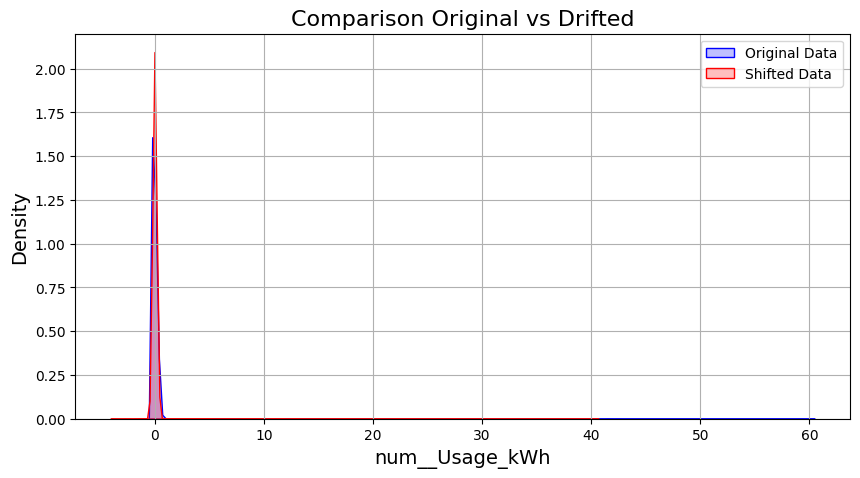

In [57]:
plt.figure(figsize=(10,5))

sns.kdeplot(X_train_proc[feature], label='Original Data', fill=True, color='blue')

sns.kdeplot(synthetic_data[feature], label='Shifted Data', fill=True, color='red')

plt.title('Comparison Original vs Drifted', fontsize=16)
plt.xlabel(feature, fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(True)